In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced

In [2]:
data = pd.read_csv('glass.data', names=['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'])
data = data.drop(columns=['Id'])
data = data.drop(columns='Ca')
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [7]:
scaler = MinMaxScaler()
data_sc = scaler.fit_transform(data.drop(columns=['Type']))
print('Original dataset shape %s' % Counter(data.Type))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(data_sc, data.Type)
print('Resampled dataset shape %s' % Counter(y_res))
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=17, train_size=0.66, shuffle=True)



Original dataset shape Counter({2: 76, 1: 70, 7: 29, 3: 17, 5: 13, 6: 9})
Resampled dataset shape Counter({1: 76, 2: 76, 3: 76, 5: 76, 6: 76, 7: 76})


In [8]:
clf = LogisticRegression(random_state=17, solver='saga', max_iter=10000).fit(X_train,y_train)
cv_sc = cross_val_score(clf, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_sc}")

Cross-Validation Scores: [0.76       0.77333333 0.62666667 0.72      ]


**Все стабільно**

In [9]:
clf.fit(X_train, y_train)

print(f'Train Score: {clf.score(X_train, y_train)}')
print(f'Test Score: {clf.score(X_test, y_test)}')

Train Score: 0.7533333333333333
Test Score: 0.7051282051282052


In [10]:
y_pred = clf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.62      0.70      0.92      0.65      0.80      0.63        23
          2       0.58      0.25      0.96      0.35      0.49      0.22        28
          3       0.48      0.68      0.88      0.57      0.77      0.59        22
          5       0.83      0.83      0.96      0.83      0.89      0.78        29
          6       0.84      1.00      0.96      0.91      0.98      0.97        26
          7       0.81      0.79      0.96      0.80      0.87      0.74        28

avg / total       0.70      0.71      0.94      0.69      0.80      0.66       156



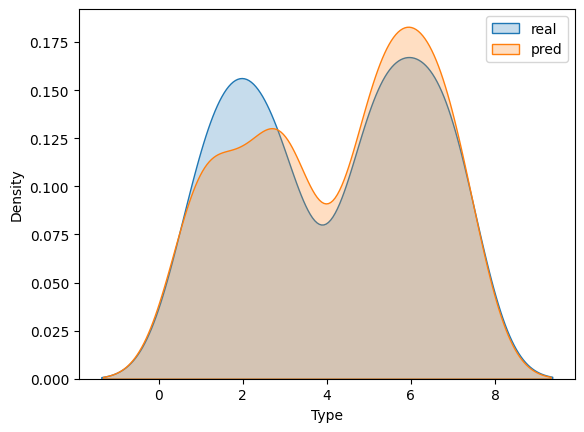

In [11]:
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(clf.predict(X_test), fill=True, label='pred')
plt.legend()

In [12]:
param_grid = {
    'penalty': ['elasticnet'],
    'l1_ratio': np.linspace(0.00001, 0.99, 50),
    'C':  np.linspace(0.0001, 10.0, 10),
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(X_train, y_train)
best_knn_reg = grid_search.best_estimator_
y_pred = best_knn_reg.predict(X_test)
print(best_knn_reg)
print(classification_report_imbalanced(y_test, y_pred))

LogisticRegression(C=10.0, l1_ratio=0.99, max_iter=10000, penalty='elasticnet',
                   random_state=17, solver='saga')
                   pre       rec       spe        f1       geo       iba       sup

          1       0.60      0.65      0.92      0.62      0.78      0.59        23
          2       0.52      0.43      0.91      0.47      0.63      0.37        28
          3       0.71      0.77      0.95      0.74      0.86      0.72        22
          5       0.91      1.00      0.98      0.95      0.99      0.98        29
          6       0.90      1.00      0.98      0.95      0.99      0.98        26
          7       1.00      0.82      1.00      0.90      0.91      0.81        28

avg / total       0.78      0.78      0.96      0.78      0.86      0.74       156



**Метод балансування oversampling виявився кращим за нічого, але порівняно з іншими методами трохи гірший**

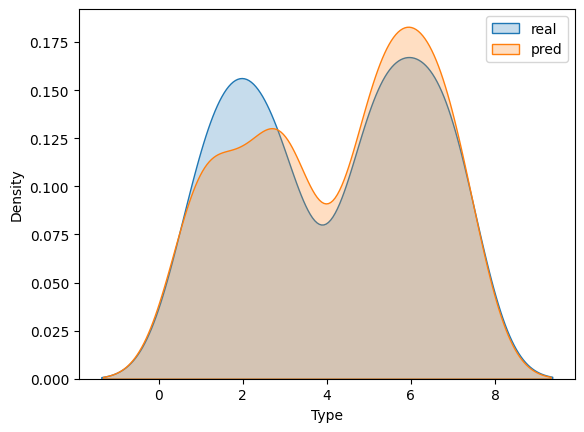

In [13]:
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(clf.predict(X_test), fill=True, label='pred')
plt.legend()